# This network is to perform embedding on the network

# Table of contents
## <a href='#Load-data'>Load data</a>
## <a href='#Embedding-with-different-parameters-using-944-edges'>Test embedding parameters</a>
## <a href='#Color-code-the-network-embedding-by-the-log2FC'>Color code network embedding by log2FC</a>
## <a href='#Color-code-the-network-embedding-by-the-community-in-the-network'>Color code network embedding by the network community</a>
## <a href='#Find-critical-genes-(share-large-weights-with-important-DEGs)'>Find critical genes by distance</a>

# Load data

In [229]:
import pandas as pd
import seaborn as sns
import numpy as np
from node2vec import Node2Vec
import networkx as nx
import umap
from networkx.algorithms.community import greedy_modularity_communities
from sklearn.metrics.pairwise import euclidean_distances
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
tom_df = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\Kapoor_TOM.csv', index_col = 0)

# Functions for network embedding, making communities/K means and plotting embedding 

In [231]:
def subset_network(network_df, weight_min, weight_max):
    subset = network_df[(network_df > weight_min) & (network_df < weight_max)]
    # remove columns if the entire column is nan, same with rows
    subset.dropna(how = 'all', inplace = True)
    subset.dropna(axis = 1, how = 'all', inplace = True)
    print('Number of edges:',len(subset))
    subset_adj = subset.stack().dropna().reset_index() # convert from wide to long to remove na
    return subset_adj

In [256]:
def network_embedding(adjacency_matrix, walk_length, num_walks, window):
    G = nx.convert_matrix.from_pandas_edgelist(adjacency_matrix, source = 'level_0', target = 'level_1')
    node2vec = Node2Vec(G, dimensions=64, walk_length=walk_length, num_walks=num_walks)
    model = node2vec.fit(window = window, min_count=1, workers = 4)
    emb_df = pd.DataFrame(np.asarray(model.wv.vectors), index = G.nodes)
    return G, emb_df

In [54]:
deseq = pd.read_excel(r'G:\Shared drives\NIAAA_ASSIST\Data\deseq.alc.vs.control.age.rin.batch.gender.PMI.corrected.w.prot.coding.gene.name.xlsx')

In [252]:
def umap_embedding(emb_df):
    umap_emb = umap.UMAP(n_neighbors = 8, min_dist = 0.3, random_state=42).fit_transform(emb_df)
    umap_df = pd.DataFrame(umap_emb, index = emb_df.index)
    umap_deseq_df = pd.merge(umap_df, deseq, left_index = True, right_on = 'id')
    sns.set(rc={'figure.figsize':(6,4)})
    sns.set(font_scale = 1.2)
    sns.set_style('white')
    cmap = sns.color_palette('RdBu_r', as_cmap=True)
    f, ax = plt.subplots()
    points = ax.scatter(umap_deseq_df.loc[:,0], umap_deseq_df.loc[:,1], c=umap_deseq_df.loc[:,'log2FoldChange'], 
                        s=2, cmap=cmap, vmin = -0.3, vmax = 0.3)
    f.colorbar(points)
    plt.title('network embedding color by log2FC');

In [381]:
def run_community_kmeans(graph, network_emb):
    # determine communities
    communities = list(greedy_modularity_communities(graph, weight = 'weight'))
    communities_df = community_to_df(network_emb, communities)
    # determine k means clusters
    n_clusters = communities_df['community'].unique().shape[0]
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(network_emb.iloc[:,:64])
    communities_df['kmean_id'] = kmeans
    return communities_df

In [313]:
def community_to_df(network_emb, communities):
    # convert the community list to dfs
    community_dfs = []
    for i, c in enumerate(communities):
        community_df = pd.DataFrame({'id':c})
        community_df['community'] = i+1
        community_dfs.append(community_df)
    community_dfs = pd.concat(community_dfs)  
    
    joined = pd.merge(network_emb, community_dfs, left_index = True, right_on = 'id')
    return joined

In [327]:
def jaccard_similarity(list1, list2):
    intersection = len(set(list1).intersection(list2))
    union = len(set(list1)) + len(set(list2)) - intersection
    return intersection / union

In [404]:
def jaccard_community_kmeans(joined_emb_df, title):
    c_list = []
    k_list = []
    j_list = []
    for c in joined_emb_df.community.unique():
        for k in joined_emb_df.kmean_id.unique():
            sub1 = joined_emb_df[joined_emb_df.community == c]['id']
            sub2 = joined_emb_df[joined_emb_df.kmean_id == k]['id']
            c_list.append(c)
            k_list.append(k)
            j_list.append(jaccard_similarity(sub1, sub2))
    jac_df = pd.DataFrame({'community':c_list, 'kmean_id':k_list, 'jaccard':j_list})
    jac_df = jac_df.pivot(index = 'community', columns = 'kmean_id', values = 'jaccard')
    plt.figure(figsize = (12,8))
    sns.heatmap(jac_df, cmap = 'Reds', xticklabels=True, yticklabels=True)
    plt.title(title)
    plt.xticks(rotation=0)

In [389]:
tom_small_subset = subset_network(tom_df, 0.16, 0.99)

Number of edges: 944


# Embedding with different parameters using 944 edges

Generating walks (CPU: 1): 100%|██████████████| 500/500 [22:24<00:00,  2.69s/it]


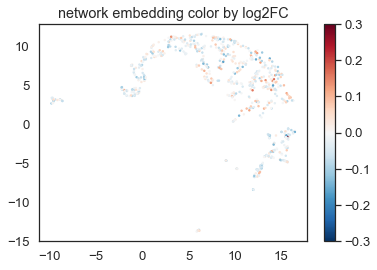

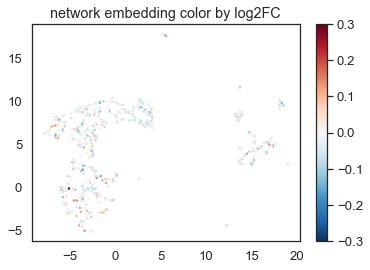

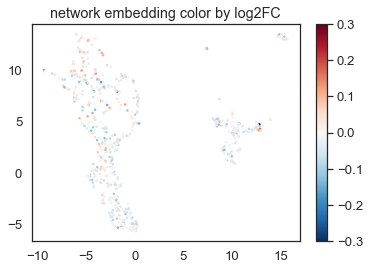

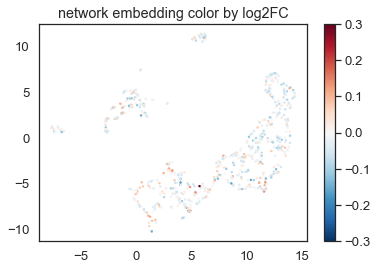

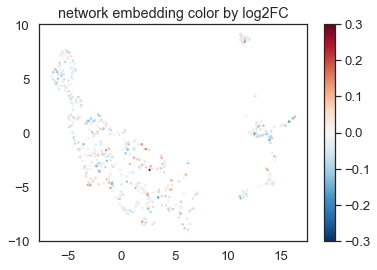

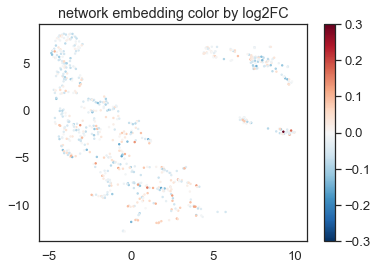

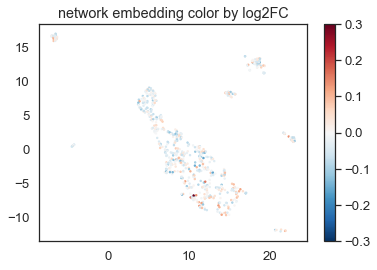

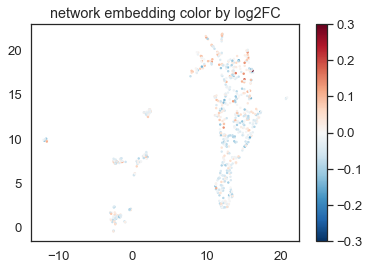

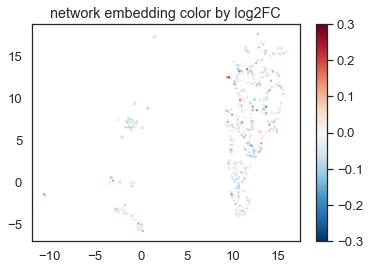

In [390]:
for length in [4, 16, 64]:
    for num_walk in [100, 300, 500]:
        G, emb_tom = network_embedding(tom_small_subset, length, num_walk, 10)
        emb_tom.to_csv(f'../data/embedded_1k_nodes_len{length}_walk{num_walk}.csv')
        umap_embedding(emb_tom)

In [392]:
os.chdir(r'C:\Users\bbche\Documents\GitRepos\assist\data')
files = os.listdir(r'C:\Users\bbche\Documents\GitRepos\assist\data')
files.pop()

'embedded_tom_10k_nodes.csv'

# Show Jaccard similarity matrix to compare communities and K means clusters from different embeddings

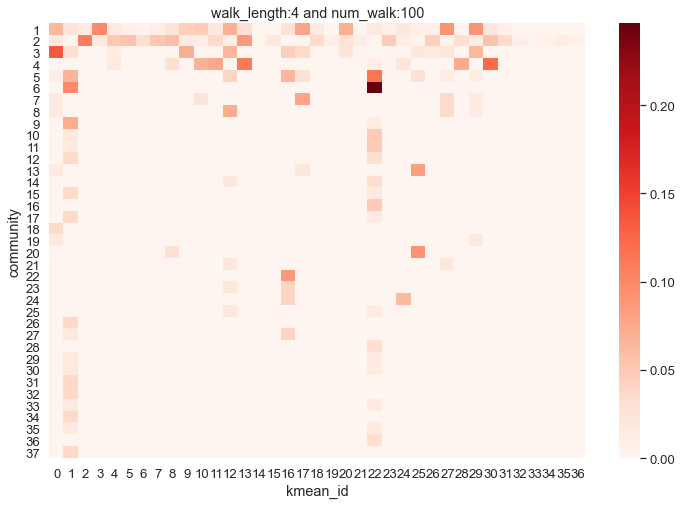

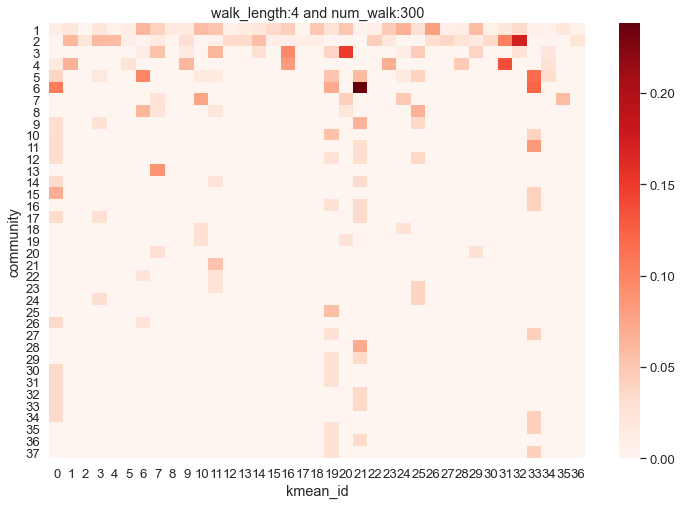

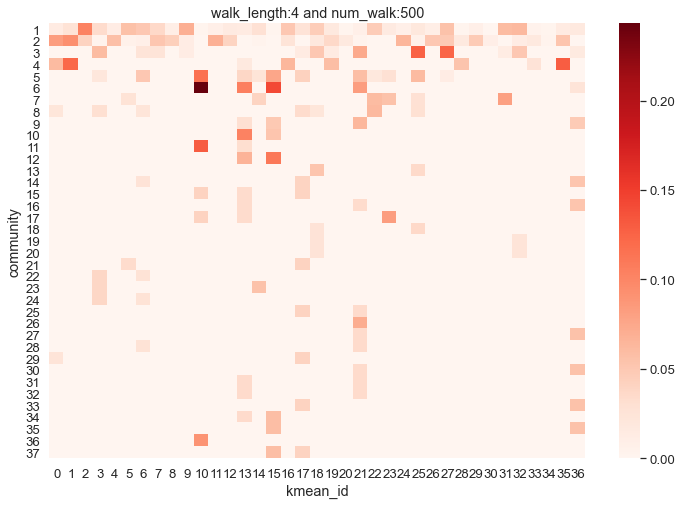

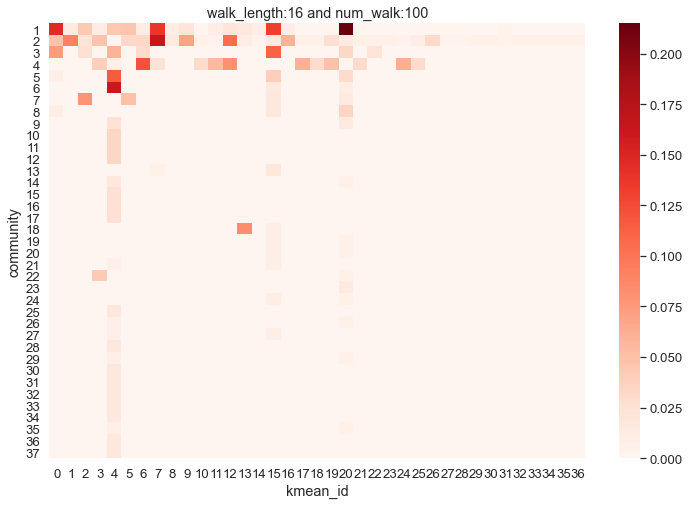

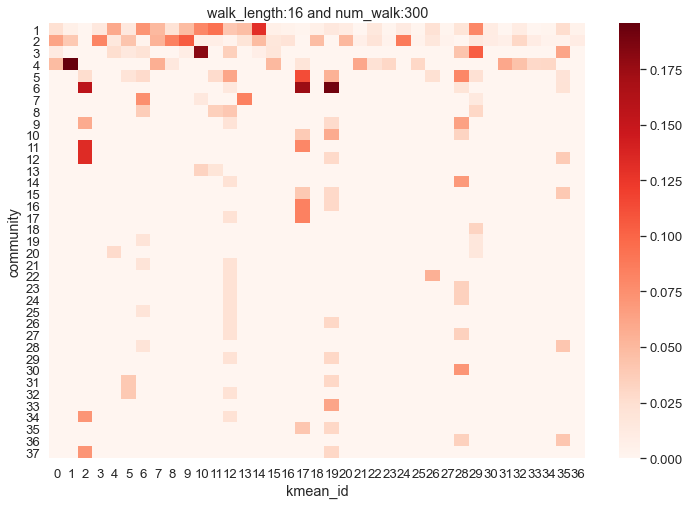

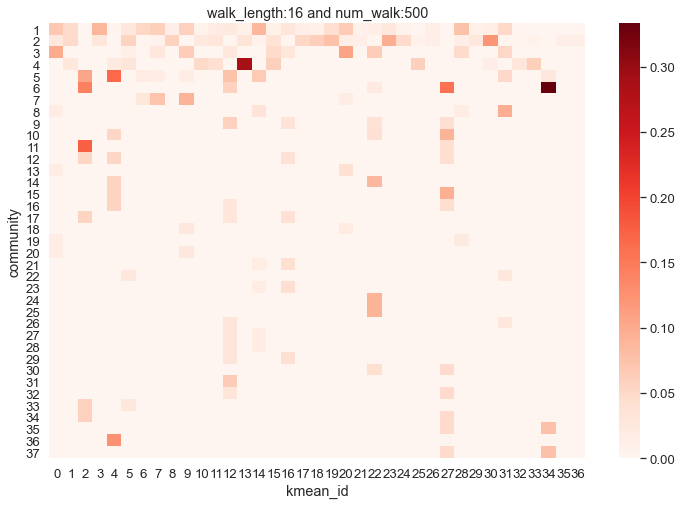

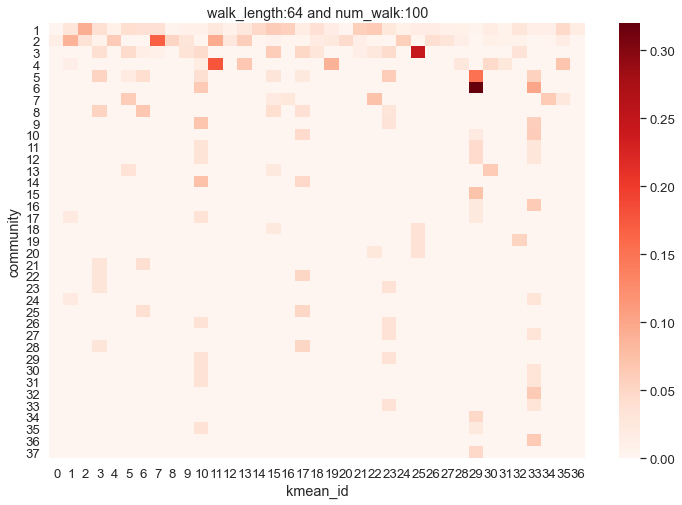

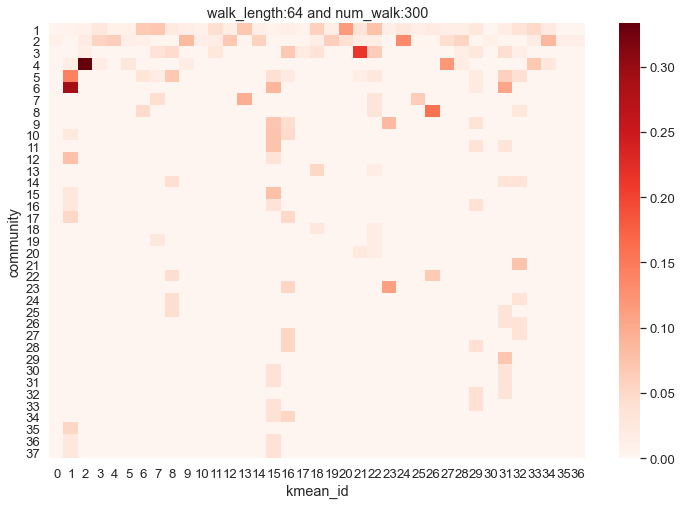

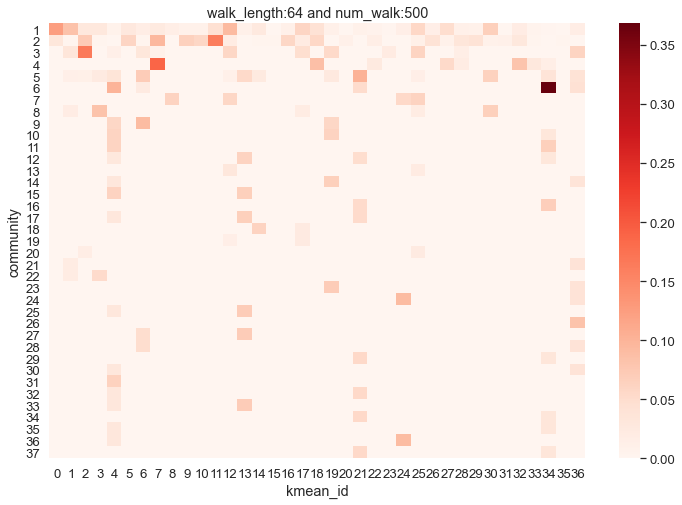

In [406]:
i = 0
for length in [4, 16, 64]:
    for num_walk in [100, 300, 500]:
        emb = pd.read_csv(files[i], index_col = 0)
        emb = run_community_kmeans(G, emb)
        jaccard_community_kmeans(emb, f'walk_length:{length} and num_walk:{num_walk}')
        i += 1

# Below is old codes for the old embedding. 

----

In [419]:
# subset to get ~10k nodes for embedding
tom_subset_adj = subset_network(tom_df, 0.038, 0.99)

Number of edges: 10332


In [9]:
# original parameters for embedding
G, emb_tom = network_embedding(tom_subset_adj, 20, 30, 10)

Generating walks (CPU: 1): 100%|██████████████████████████████████| 30/30 [09:24<00:00, 18.80s/it]


# compare network weights and embedding similarity

In [10]:
emb_tom.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ENSG00000225972,1.393376,2.364104,0.924181,-1.359552,0.255054,-3.505159,-0.478653,-2.195205,0.155982,0.858752,...,-2.023527,0.857552,1.072483,-0.784817,0.778312,0.633677,0.554484,-1.006713,-1.223501,3.469553
ENSG00000248527,1.047772,1.042343,-0.227155,-1.952965,1.239519,-3.791575,-0.007238,-1.567714,-0.370616,0.336916,...,-1.939454,1.041997,1.411569,-1.331061,1.411458,0.989266,-0.066137,-1.064632,-1.648062,3.228506
ENSG00000247627,-1.672903,2.480142,-1.726018,-0.895374,2.334948,-3.126973,-1.559427,0.004151,-0.174930,-1.649766,...,-0.118189,1.771619,-1.011333,-0.905432,0.659894,0.984395,0.870113,-2.218727,-4.248143,3.326764
ENSG00000229344,-1.147449,3.110958,-1.343219,-0.572078,1.333684,-2.305519,-1.582527,-0.028142,0.164567,-0.984249,...,-0.357066,1.994137,-1.074692,-0.864565,0.070010,1.591805,1.184363,-1.798530,-5.011013,3.550456
ENSG00000228794,-0.035066,1.736092,-1.197768,-1.629311,3.048221,-3.133106,-0.818397,-0.065439,-0.414820,-1.567795,...,-0.621054,1.306895,-1.308329,-0.460558,1.922629,0.720580,0.347959,-2.273552,-3.447134,2.724521


In [11]:
umap_emb = umap.UMAP(n_neighbors = 8, min_dist = 0.3, random_state=42).fit_transform(emb_tom)
umap_df = pd.DataFrame(umap_emb, index = emb_tom.index)

In [20]:
# get the top 10 nodes that share large weights with ENSG00000233864 as an example
similar_to_64 = tom_subset_adj[tom_subset_adj.level_0 == 'ENSG00000233864'].sort_values(by = 0)['level_1'][:10].tolist()

In [22]:
similar_to_64.append('ENSG00000233864')

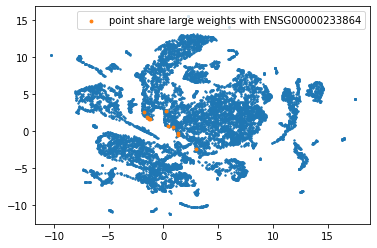

In [23]:
# plot umap and show 10 nodes that share large weights with ENSG00000233864 to see how they distribute on the umap
plt.scatter(umap_emb[:, 0], umap_emb[:, 1], s = 2)
plt.scatter(umap_df.loc[umap_df.index.isin(similar_to_64), 0], umap_df.loc[umap_df.index.isin(similar_to_64), 1], s = 8, 
            label = 'point share large weights with ENSG00000233864')
plt.legend()

# Color code the network embedding by the log2FC

In [54]:
deseq = pd.read_excel(r'G:\Shared drives\NIAAA_ASSIST\Data\deseq.alc.vs.control.age.rin.batch.gender.PMI.corrected.w.prot.coding.gene.name.xlsx')

In [55]:
umap_deseq_df = pd.merge(umap_df, deseq, left_on = 'id', right_on = 'id')

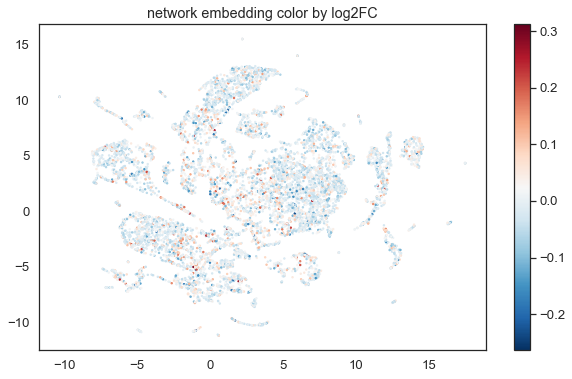

In [158]:
sns.set(rc={'figure.figsize':(10,6)})
sns.set(font_scale = 1.2)
sns.set_style('white')
cmap = sns.color_palette('RdBu_r', as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(umap_deseq_df.loc[:,0], umap_deseq_df.loc[:,1], c=umap_deseq_df.loc[:,'log2FoldChange'], s=2, cmap=cmap)
f.colorbar(points)
plt.title('network embedding color by log2FC');

## Show impact genes

In [114]:
up_impact = deseq[(deseq['log2FoldChange'] > 0.05) & (deseq['padj'] < 0.2)]['id']

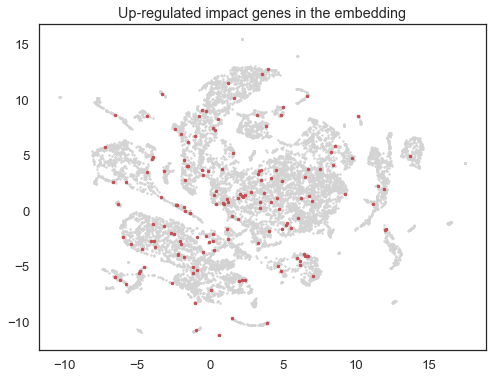

In [127]:
sns.set(rc={'figure.figsize':(8,6)})
sns.set(font_scale = 1.2)
sns.set_style('white')
plt.scatter(umap_emb[:, 0], umap_emb[:, 1], s = 2, c = '#D3D3D3')
plt.scatter(umap_deseq_df.loc[umap_deseq_df.id.isin(up_impact), 0], umap_deseq_df.loc[umap_deseq_df.id.isin(up_impact),1], s=6, c = 'r')
plt.title('Up-regulated impact genes in the embedding');

In [117]:
down_impact = deseq[(deseq['log2FoldChange'] < -0.05) & (deseq['padj'] < 0.2)]['id']

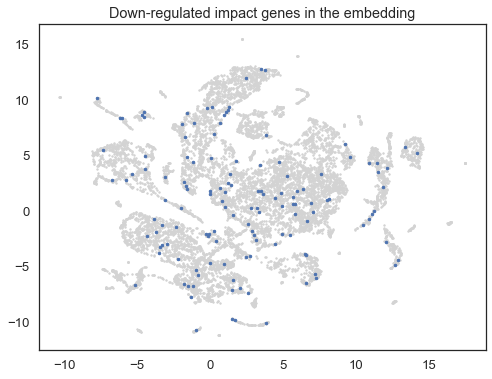

In [125]:
sns.set(rc={'figure.figsize':(8,6)})
sns.set(font_scale = 1.2)
sns.set_style('white')
plt.scatter(umap_emb[:, 0], umap_emb[:, 1], s = 2, c = '#D3D3D3')
plt.scatter(umap_deseq_df.loc[umap_deseq_df.id.isin(down_impact), 0], umap_deseq_df.loc[umap_deseq_df.id.isin(down_impact),1], s=6, c = 'b')
plt.title('Down-regulated impact genes in the embedding');

# Color code the network embedding by the community in the network

In [27]:
communities = list(greedy_modularity_communities(G, weight = 'weight'))

In [28]:
# convert the community list to dfs
community_dfs = []
for i, c in enumerate(communities):
    community_df = pd.DataFrame({'id':c})
    community_df['community'] = i+1
    community_dfs.append(community_df)
community_dfs = pd.concat(community_dfs)   

In [29]:
emb_tom = pd.merge(emb_tom, community_dfs, left_index = True, right_on = 'id')

In [31]:
emb_tom.to_csv(r'C:\Users\bbche\Documents\GitRepos\assist\data\embedded_tom_10k_nodes.csv')

In [32]:
# join community label to umap df
umap_df = pd.merge(umap_df, community_dfs, left_index = True, right_on = 'id')

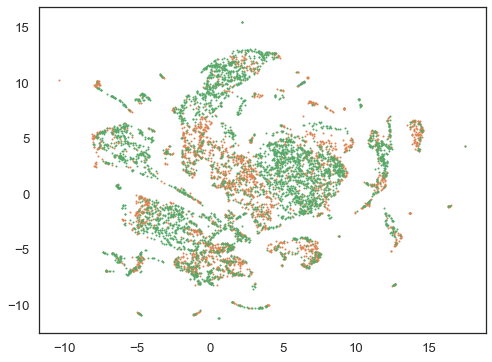

In [296]:
plt.figure(figsize = (8,6))
for c in emb_tom.community.unique()[:3]:
    subset = emb_tom[emb_tom.community == c]
    plt.scatter(subset['UMAP1'], subset['UMAP2'], s = 1)

In [295]:
emb_tom.community.value_counts()

1      3889
2      3022
3      2843
4       203
5       137
       ... 
116       2
124       2
53        2
61        2
123       2
Name: community, Length: 125, dtype: int64

# k means to cluster genes

In [286]:
kmeans = KMeans(n_clusters=125, random_state=0).fit_predict(emb_tom.iloc[:,:100])

In [287]:
emb_tom['kmean_id'] = kmeans # save for later
umap_df['kmean_id'] = kmeans

In [288]:
umap_df['kmean_id'] = kmeans

In [290]:
emb_tom.head()

,0,1,2,3,4,5,6,7,8,9,...,98,99,id,community,kmean_id,UMAP1,UMAP2,PCA1,PCA2,encoded_id
1,1.393376,2.364104,0.924181,-1.359552,0.255054,-3.505159,-0.478653,-2.195205,0.155982,0.858752,...,-1.223501,3.469553,ENSG00000225972,25,41,6.141463,9.901323,11.846164,-6.146509,8802
2,1.047772,1.042343,-0.227155,-1.952965,1.239519,-3.791575,-0.007238,-1.567714,-0.370616,0.336916,...,-1.648062,3.228506,ENSG00000248527,25,90,6.240291,9.992508,10.274141,-9.221477,9620
0,-1.672904,2.480142,-1.726018,-0.895374,2.334948,-3.126973,-1.559427,0.004151,-0.174930,-1.649766,...,-4.248143,3.326764,ENSG00000247627,25,64,6.418515,10.130126,7.090662,-13.153276,9599
3,-1.147449,3.110958,-1.343219,-0.572078,1.333684,-2.305519,-1.582527,-0.028142,0.164567,-0.984249,...,-5.011013,3.550456,ENSG00000229344,25,64,6.399878,10.105440,7.494497,-12.534487,8952
189,-0.035066,1.736092,-1.197768,-1.629311,3.048221,-3.133106,-0.818397,-0.065439,-0.414820,-1.567795,...,-3.447134,2.724521,ENSG00000228794,3,90,6.390002,10.071210,7.264127,-12.449380,8923


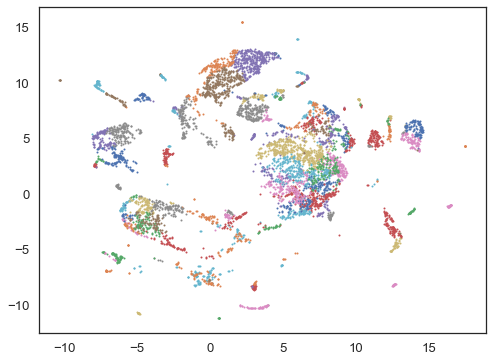

In [292]:
plt.figure(figsize = (8,6))
for c in emb_tom.kmean_id.unique()[:100]:
    subset = emb_tom[emb_tom.kmean_id == c]
    plt.scatter(subset['UMAP1'], subset['UMAP2'], s = 1)

# Find critical genes (share large weights with important DEGs)

In [197]:
high_impact_genes = deseq[(deseq['log2FoldChange'] > 0.25)|(deseq['log2FoldChange'] < -0.25) & (deseq['padj'] < 0.05)]['id']

In [160]:
# determine euclidean distance between genes based on embedding
emb_tom_similarity = euclidean_distances(emb_tom.iloc[:,:100])

In [180]:
emb_tom_similarity = pd.DataFrame(emb_tom_similarity)
emb_tom_similarity.columns = emb_tom.id
emb_tom_similarity.index = emb_tom.id

In [201]:
# loop through the similarity matrix to get genes that have similar euclidean distance from high impact genes
critical_genes = []
for gene in up_deg:
    try:
        subset = emb_tom_similarity[gene]
        if len(subset[subset < 3].index) > 1: # if there is more than 1 gene that has distance < 3 with a high_impact_gene, it's probably a critical gene
            critical_genes += list(subset[subset < 3].index)
    except:
        print(index, 'not in the network')

ENSG00000096060 not in the network
ENSG00000096060 not in the network


In [202]:
len(critical_genes)

4430

In [203]:
# count how many time a critical occur. if more than once, it means it is close to more than 1 high impact gene
critical_gene_dict = Counter(critical_genes)

In [139]:
# use PCA for 2D representation since it is linear dimensionality reduction, should be more ideal to show distance measured by euclidean distance
pca = PCA(n_components = 2)
emb_tom_pca = pca.fit_transform(emb_tom.iloc[:,:100])

In [204]:
critical_gene_list = sorted(critical_gene_dict.items(), key=lambda x: x[1], reverse=True)

In [217]:
print(critical_gene_list[0][0])
print(critical_gene_list[1])
print(critical_gene_list[2])

ENSG00000197070
('ENSG00000103363', 3)
('ENSG00000227543', 3)


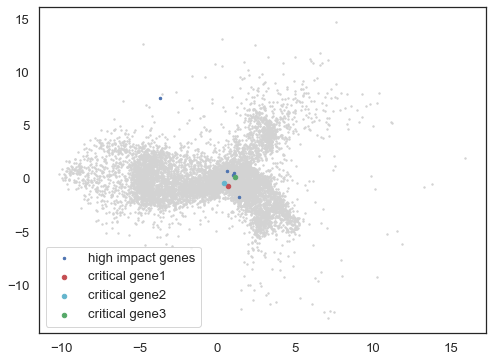

In [222]:
color_list = ['r','c','g']
plt.scatter(emb_tom_pca[:, 0], emb_tom_pca[:, 1], s = 2, c = '#D3D3D3')
plt.scatter(emb_tom_pca[emb_tom.id.isin(up_deg), 0], emb_tom_pca[emb_tom.id.isin(up_deg),1], s=6, c = 'b', label = 'high impact genes')
for i in range(3):
    plt.scatter(emb_tom_pca[emb_tom.id == critical_gene_list[i][0], 0], emb_tom_pca[emb_tom.id == critical_gene_list[i][0],1], s=20, c = color_list[i], label = f'critical gene{i+1}')
plt.legend();


In [192]:
emb_tom[['UMAP1', 'UMAP2']] = umap_emb
emb_tom[['PCA1','PCA2']] = emb_tom_pca

In [196]:
emb_tom.to_csv(r'C:\Users\bbche\Documents\GitRepos\assist\data\embedded_tom_10k_nodes.csv')

# Jaccard similarity to compare community and k mean clusters

In [265]:
emb_tom = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\assist\data\embedded_tom_10k_nodes.csv', index_col = 0)

In [266]:
emb_tom.shape

,0,1,2,3,4,5,6,7,8,9,...,97,98,99,id,community,kmean_id,UMAP1,UMAP2,PCA1,PCA2
1,1.393376,2.364104,0.924181,-1.359552,0.255054,-3.505159,-0.478653,-2.195205,0.155982,0.858752,...,-1.006713,-1.223501,3.469553,ENSG00000225972,25,5,6.141463,9.901323,11.846164,-6.146509
2,1.047772,1.042343,-0.227155,-1.952965,1.239519,-3.791575,-0.007238,-1.567714,-0.370616,0.336916,...,-1.064632,-1.648062,3.228506,ENSG00000248527,25,5,6.240291,9.992508,10.274141,-9.221477
0,-1.672904,2.480142,-1.726018,-0.895374,2.334948,-3.126973,-1.559427,0.004151,-0.174930,-1.649766,...,-2.218727,-4.248143,3.326764,ENSG00000247627,25,5,6.418515,10.130126,7.090662,-13.153276
3,-1.147449,3.110958,-1.343219,-0.572078,1.333684,-2.305519,-1.582527,-0.028142,0.164567,-0.984249,...,-1.798530,-5.011013,3.550456,ENSG00000229344,25,5,6.399878,10.105440,7.494497,-12.534487
189,-0.035066,1.736092,-1.197768,-1.629311,3.048221,-3.133106,-0.818397,-0.065439,-0.414820,-1.567795,...,-2.273552,-3.447134,2.724521,ENSG00000228794,3,5,6.390002,10.071210,7.264127,-12.449380


In [271]:
emb_tom.shape

(10560, 107)

In [278]:
def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    print(intersection)
    return float(intersection) / union

In [300]:
emb_tom['kmean_id'].value_counts(normalize = True)

38     0.041761
59     0.031913
45     0.029830
110    0.025758
83     0.025095
         ...   
98     0.000379
65     0.000379
41     0.000379
64     0.000284
90     0.000284
Name: kmean_id, Length: 125, dtype: float64

In [299]:
3889+3022+2843

9754

In [285]:
emb_tom['kmean_id'].unique().shape

(20,)

In [281]:
jaccard(emb_tom[emb_tom['community'] == 1]['id'], emb_tom[emb_tom['kmean_id'] == 1]['id'])

96


0.023680315737543166

In [272]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
emb_tom['encoded_id'] = le.fit_transform(emb_tom['id'])

In [275]:
emb_tom[emb_tom['community'] == 1]

,0,1,2,3,4,5,6,7,8,9,...,98,99,id,community,kmean_id,UMAP1,UMAP2,PCA1,PCA2,encoded_id
1103,2.338414,4.688205,2.378149,-1.415140,-1.258537,-3.458532,-1.031141,-2.570965,0.477306,0.915932,...,-0.293624,3.162560,ENSG00000196876,1,5,6.038714,9.798190,11.538495,-4.896489,7928
872,-0.037466,1.545600,-0.225234,-1.072931,2.293301,-3.290751,-0.809901,-0.168248,0.163187,-1.354812,...,-2.927891,2.723114,ENSG00000183454,1,5,6.415104,10.149153,6.078413,-11.754754,7390
910,1.908358,3.720155,2.078369,-0.943021,-0.771713,-3.223752,-0.712725,-2.212357,0.475173,1.111361,...,-0.315129,2.765906,ENSG00000170579,1,5,6.070235,9.843734,10.930649,-5.200908,6440
957,1.276709,2.654345,1.253332,-0.399965,-0.306384,-3.363122,-1.159736,-0.868069,0.992590,-0.539648,...,-2.415142,2.551796,ENSG00000188976,1,5,6.320040,10.074820,6.468515,-9.662503,7792
2960,1.755199,2.896049,1.699806,-0.084160,-1.091353,-3.590394,-1.265636,-1.453722,0.493817,0.176578,...,-1.088305,2.715777,ENSG00000167792,1,5,6.187554,9.955178,7.947147,-7.661165,6188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3554,-0.277560,0.090694,-0.027834,0.227164,0.369638,0.136549,-0.082081,-0.045111,-0.094218,-0.197610,...,-0.145990,-0.027824,ENSG00000224223,1,17,-1.560576,4.121565,0.396456,-0.362725,8707
2475,-0.007334,-0.090549,-0.028725,0.012730,-0.001062,-0.029260,0.073036,-0.029103,-0.023477,0.109196,...,-0.031562,-0.003845,ENSG00000164465,1,17,-1.283816,1.908264,0.112922,0.126521,5823
2414,-0.074112,-0.122360,0.067383,0.118738,0.098062,-0.111745,0.077524,-0.012211,-0.069189,-0.059660,...,0.098017,0.081787,ENSG00000260317,1,17,1.595722,-0.506954,-0.024031,0.011224,10119
2259,-0.081760,-0.135560,0.078711,0.215453,0.152129,-0.118244,0.006392,-0.134840,-0.107212,0.039913,...,-0.275459,0.088187,ENSG00000104361,1,17,1.254953,-0.379909,-0.026598,-0.282110,1620


In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
jac_sim = 1 - pairwise_distances(, metric = "hamming")

In [270]:
from sklearn.metrics import jaccard_score
jaccard_score(['a','b'],['a','a'])

C:\Users\bbche\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:


ValueError: pos_label=1 is not a valid label: array(['a', 'b'], dtype='<U1')